Construindo o CFA...


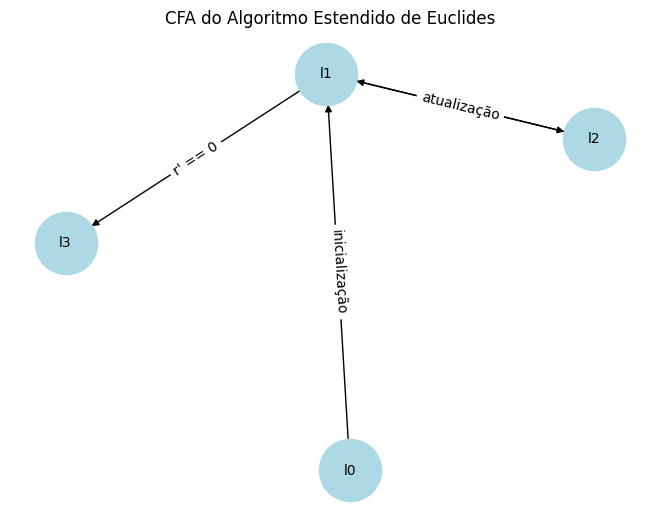

Verificando o programa com Z3...
Falha na verificação da propriedade.


In [12]:
import networkx as nx
import matplotlib.pyplot as plt
from z3 import *

# Função para construir e exibir o CFA
def construir_cfa():
    # Criar o grafo dirigido
    cfa = nx.DiGraph()

    # Adicionar nós (locais)
    cfa.add_nodes_from(["l0", "l1", "l2", "l3"])

    # Adicionar transições entre os locais
    cfa.add_edges_from([
        ("l0", "l1", {"condição": "inicialização"}),
        ("l1", "l2", {"condição": "r' != 0"}),
        ("l2", "l1", {"condição": "atualização"}),
        ("l1", "l3", {"condição": "r' == 0"})
    ])

    # Desenhar o grafo
    pos = nx.spring_layout(cfa)  # Layout para posicionar os nós
    nx.draw(cfa, pos, with_labels=True, node_size=2000, node_color="lightblue", font_size=10)
    nx.draw_networkx_edge_labels(cfa, pos, edge_labels=nx.get_edge_attributes(cfa, "condição"))
    plt.title("CFA do Algoritmo Estendido de Euclides")
    plt.show()

# Função para verificar o programa com Z3
def verificar_programa():
    # Variáveis
    a, b = Ints('a b')
    r, rp, s, sp, t, tp = Ints('r rp s sp t tp')
    q = Int('q')

    # Inicialização
    solver = Solver()
    solver.add(a > 0, b > 0)  # Pré-condição
    solver.add(r == a, rp == b, s == 1, sp == 0, t == 0, tp == 1)

    # Laço (uma iteração como exemplo)
    solver.add(rp != 0)  # Condição do laço
    solver.add(q == r / rp)  # Quociente usando divisão normal
    solver.add(r == rp, rp == r - q * rp)  # Atualização de r e rp
    solver.add(s == sp, sp == s - q * sp)  # Atualização de s e sp
    solver.add(t == tp, tp == t - q * tp)  # Atualização de t e tp

    # Verificar se o algoritmo preserva a relação a*s + b*t = gcd(a, b)
    gcd_condition = (a * s + b * t == r)
    solver.add(gcd_condition)

    # Resolver
    if solver.check() == sat:
        print("Propriedade verificada. Modelo:")
        print(solver.model())
    else:
        print("Falha na verificação da propriedade.")

# Função principal que executa ambas as partes
def main():
    print("Construindo o CFA...")
    construir_cfa()
    print("Verificando o programa com Z3...")
    verificar_programa()

# Executar a função principal
if __name__ == "__main__":
    main()
